# implement PR AUC precision(tp/tp+fp) vs recall (tp/tp+fn)

In [1]:
import torch
import matplotlib.pyplot as plt
import concurrent.futures as cf

In [56]:
vld_pred = torch.load('../tmp/vld_pred')

In [4]:
input, targ = vld_pred
input, targ = input[:,0], targ[:,0]

In [5]:
targ = (targ == 1)
desc_score_indices = input.argsort(descending=True)
input = input.gather(-1,desc_score_indices)
targ  = targ.gather(-1,desc_score_indices)
d = input[1:] - input[:-1] #[7999]
distinct_value_indices = torch.nonzero(d).transpose(0,1)[0] #[7995]
threshold_idxs = torch.cat((distinct_value_indices, torch.LongTensor([len(targ) - 1]).to(targ.device))) #[7996]


tps = torch.cumsum(targ * 1, dim=-1)[threshold_idxs]
fps = (1 + threshold_idxs - tps)
if tps[0] != 0 or fps[0] != 0:
    zer = fps.new_zeros(1)
    fps = torch.cat((zer, fps))
    tps = torch.cat((zer, tps))
fpr, tpr = fps.float() / fps[-1], tps.float() / tps[-1]

In [52]:
ppv = tps.float()/(tps+fps).float()
ppv[0]= 0 #0/0 = nan
ppv

tensor([0.0000, 0.0000, 0.5000,  ..., 0.0248, 0.0248, 0.0247])

In [50]:
tps+fps

tensor([   0,    1,    2,  ..., 7998, 7999, 8000])

In [13]:
d = fpr[1:] - fpr[:-1]
sl1, sl2 = [slice(None)], [slice(None)]
sl1[-1], sl2[-1] = slice(1, None), slice(None, -1)
(d * (tpr[tuple(sl1)] + tpr[tuple(sl2)]) / 2.).sum(-1)

tensor(0.8222)

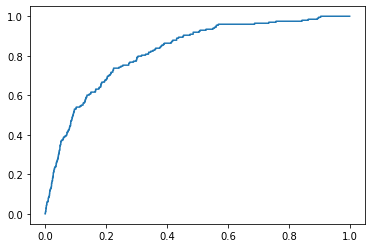

In [45]:
plt.plot(fpr.numpy(),tpr.numpy())

In [54]:
d = tpr[1:] - tpr[:-1]
sl1, sl2 = [slice(None)], [slice(None)]
sl1[-1], sl2[-1] = slice(1, None), slice(None, -1)
(d * (ppv[tuple(sl1)] + ppv[tuple(sl2)]) / 2.).sum(-1)

tensor(0.1135)

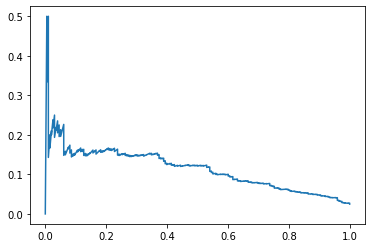

In [53]:
plt.plot(tpr.numpy(),ppv.numpy())

In [47]:
ppv

tensor([0.0000, 0.0000, 0.0001,  ..., 0.0247, 0.0247, 0.0247])

In [2]:
def roc_pr_curves(input, targ):
    targ = (targ == 1)
    desc_score_indices = input.argsort(descending=True)
    input = input.gather(-1,desc_score_indices)
    targ  = targ.gather(-1,desc_score_indices)
    d = input[1:] - input[:-1]
    distinct_value_indices = torch.nonzero(d).transpose(0,1)[0]
    threshold_idxs = torch.cat((distinct_value_indices, torch.LongTensor([len(targ) - 1]).to(targ.device)))
    tps = torch.cumsum(targ * 1, dim=-1)[threshold_idxs]
    fps = (1 + threshold_idxs - tps)
    if tps[0] != 0 or fps[0] != 0:
        zer = fps.new_zeros(1)
        fps = torch.cat((zer, fps))
        tps = torch.cat((zer, tps))
    fpr, tpr = fps.float() / fps[-1], tps.float() / tps[-1]
    ppv = tps.float()/(tps+fps).float()
    ppv[0]= 0 #0/0 = nan
    return fpr, tpr, ppv

def auc_scores(input, targ):
    fpr, tpr, ppv = roc_pr_curves(input, targ)
    d = fpr[1:] - fpr[:-1]
    sl1, sl2 = [slice(None)], [slice(None)]
    sl1[-1], sl2[-1] = slice(1, None), slice(None, -1)
    roc_auc = (d * (tpr[tuple(sl1)] + tpr[tuple(sl2)]) / 2.).sum(-1)
    
    d = tpr[1:] - tpr[:-1]
    sl1, sl2 = [slice(None)], [slice(None)]
    sl1[-1], sl2[-1] = slice(1, None), slice(None, -1)
    pr_auc = (d * (ppv[tuple(sl1)] + ppv[tuple(sl2)]) / 2.).sum(-1)
    return roc_auc,pr_auc


def weighted_aucs(inputs,targets, weights):
    idxs = list(range(inputs.shape[1]))
    auc_i = lambda i: auc_scores(inputs[:,i],targets[:,i])

    with cf.ThreadPoolExecutor() as exc:
        results = exc.map(auc_i,idxs)
    results = torch.stack([torch.stack(i) for i in results])
    
    weight_aucs = results*weights[:,None]
    weight_aucs[torch.isnan(weight_aucs)] = 0
    return weight_aucs.sum(0)

In [3]:
input, targ = torch.load('../tmp/vld_pred')
class_weights = torch.load('../data/Processed/class_weights')

In [4]:
weighted_aucs(input, targ,class_weights)

tensor([0.5981, 0.0970])

# https://github.com/HaebinShin/grad-cam-text

In [ ]:
#https://arxiv.org/pdf/1610.02391.pdf